In [16]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
from icecream import ic
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

In [2]:
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/vit"

In [3]:


# Load CIFAR-10 training data
transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=len(train_set), shuffle=False)

# Calculate mean and standard deviation
data = next(iter(train_loader))[0]
ic(data.shape)
mean = torch.mean(data, dim=[0, 2, 3])
std = torch.std(data, dim=[0, 2, 3])

print(f'Mean: {mean}\nStd: {std}')


Files already downloaded and verified


ic| data.shape: torch.Size([50000, 3, 32, 32])


Mean: tensor([0.4914, 0.4822, 0.4465])
Std: tensor([0.2470, 0.2435, 0.2616])


In [4]:
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean, std)
                                     ])
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32), scale=(0.8,1.0), ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)
                                      ])

Files already downloaded and verified
Files already downloaded and verified


Seed set to 42
Seed set to 42


Files already downloaded and verified


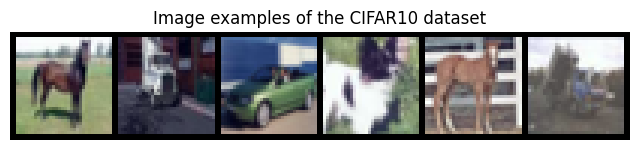

In [5]:
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform,
                        download=True)
pl.seed_everything(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
pl.seed_everything(42)
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True, drop_last=False)

test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=True, drop_last=False)


num_images = 6
CIFAR_images = torch.stack([val_set[idx][0] for idx in range(num_images)])
image_grid = torchvision.utils.make_grid(CIFAR_images, nrow=num_images, normalize=True)
image_grid = image_grid.permute(1,2,0)
plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(image_grid)
plt.axis('off')
plt.show()
plt.close()


In [6]:
image_grid.shape

torch.Size([36, 206, 3])

In [7]:
print(train_dataset[1][0].shape)
print(len(test_set))
print(len(val_dataset))

torch.Size([3, 32, 32])
10000
50000


In [8]:
train_dataset[0][0].shape   

torch.Size([3, 32, 32])

In [9]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    # ic(x)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    # ic(x)
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    # ic(x)
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
        # ic(x)
    return x

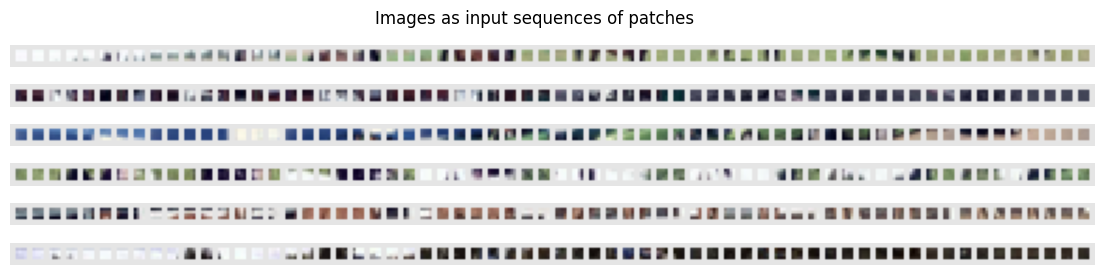

In [10]:
img_patches = img_to_patch(CIFAR_images, patch_size=4, flatten_channels=False)

fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(14,3))
fig.suptitle("Images as input sequences of patches")
for i in range(CIFAR_images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()

In [11]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )
        def forward(self, x):
            inp_x = self.layer_norm_1(x)
            x = x + self.attn(inp_x, inp_x, inp_x)[0]
            x = x + self.linear(self.layer_norm_2(x))
            return x
    pass

In [12]:
class VisionTransformer(nn.Module):
        def __init__(self, embed_dim, hidden_dim, num_channels, num_heads, num_layers,
                 num_classes, patch_size, num_patches, dropout):
                super().__init__()
                self.patch_size = patch_size

                self.input_layer = nn.Linear(num_channels*(patch_size**2), embed_dim)
                self.transformer = nn.Sequential(*[AttentionBlock(embed_dim, hidden_dim,
                        num_heads, dropout) for _ in range(num_layers)])
                self.mlp_head = nn.Sequential(nn.LayerNorm(embed_dim),
                                        nn.Linear(embed_dim, num_classes))
                self.dropout = nn.Dropout(dropout)

                self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
                self.pos_embeddings = nn.Parameter(torch.randn(1, 1+num_patches,embed_dim))

        def forward(self, x):
                x = img_to_patch(x, self.patch_size)
                B, T, _ = x.shape
                x = self.input_layer(x)
                
                cls_token = self.cls_token.repeat(B, 1, 1)
                x = torch.cat([cls_token, x], dim=1)
                x = x + self.pos_embeddings[:, :T+1]

                x = self.dropout(x)
                x = x.transpose(0,1)
                x = self.transformer(x)

                cls = x[0]
                out = self.mlp_head(cls)
                return out
        pass

In [13]:
from pytorch_lightning.loggers import WandbLogger

In [17]:
class ViT(pl.LightningModule):
    def __init__(self, model_kwargs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.model = VisionTransformer(**model_kwargs)
        self.example_input_array = next(iter(train_loader))[0]
    def forward(self, x):
        return self.model(x)
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer], [lr_scheduler]
        pass
    def _calculate_loss(self, batch, mode='train'):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) ==labels).float().mean()
        
        self.log(f'{mode}_loss', loss)
        self.log(f'{mode}_acc', acc)
        return loss
        pass
    
    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode='train')
        return loss

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')
    

In [18]:
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

In [15]:
def train_model(**kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'ViT'),
                         accelerator='gpu', devices=1, max_epochs=180,
                         callbacks=[ModelCheckpoint(save_weights_only=True, monitor='val_acc', mode='max'),
                                    LearningRateMonitor('epoch')])
        # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ViT.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = ViT.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42) # To be reproducable
        model = ViT(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = ViT.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result
    pass